In [9]:
import numpy as np
import skimage as ski
import skimage.io as skio
import PIL as pil
import PIL.Image as pilimg
import matplotlib.pyplot as plt
import cv2
import os
import open3d as o3d

- get second image and add evaluation metric
- fully complete label propogation with quadratic criteria
- understand label propogation and its assumptions
- 

steps:
1. estimate trimap with sato filter and multi otsu thresholding
   1. how does the Sato filter work
   2. how does multi otsu work
   3. rmse
2. use label propogation with a weighted knn algorithm
   1. assumptions
   2. optimisation
   3. sanity check
3. remove small objects
   1. calculate objects as contiguous parts
   2. create minimum size for an object
4. 3D projection
   1. orthographic projection
   2. fast so we assume 0 movement of the worm (in reality it is minimal but we can't quantify)
   3. conversion to 3d coordinate space (1 um in all dimensions)
   4. statistical outlier detection (knn on point cloud)
5. mesh generation
   1. understand the alpha shape algorithm [https://www.cs.jhu.edu/~misha/Fall13b/Papers/Edelsbrunner93.pdf]
6. measuring

In [10]:
# create input and save

actual_files = os.listdir('Actual files')

input_image = np.zeros([1024, 1024, 1])
for file in actual_files:
    img = pilimg.open('Actual files/' + file)
    input_image  = np.concatenate((input_image, np.array(img).reshape(1024, 1024, 1)), axis=2)

input_image = input_image[:, :, 1:]

np.save('input_image.npy', input_image)

In [11]:
# create trimap and save

trimap_files = os.listdir('Worm 1_trimaps')

input_trimap = np.zeros([1024, 1024, 1])
for file in trimap_files:
    img = pilimg.open('Worm 1_trimaps/' + file)
    input_trimap  = np.concatenate((input_trimap, np.array(img)[:,:,0].reshape(1024, 1024, 1)), axis=2)

input_trimap = input_trimap[:, :, 1:]

np.save('input_trimap.npy', input_trimap)

In [12]:
input_image = np.load('input_image.npy')
input_trimap = np.load('input_trimap.npy')

In [13]:
from skimage.filters import threshold_multiotsu

def image_to_trimap(image):
    sato = ski.filters.sato(input_image, sigmas=range(3, 5, 5), black_ridges=False, mode='constant', cval=0)
    
    thresholds = threshold_multiotsu(sato, classes=3)

    regions = np.digitize(sato, bins=thresholds)
    
    scaled_regions = regions * 128
    scaled_regions[scaled_regions > 255] = 255
    
    return scaled_regions

In [14]:
output_trimap = image_to_trimap(input_image)

In [15]:
np.sqrt(np.mean((output_trimap - input_trimap) ** 2))

28.476046726131596

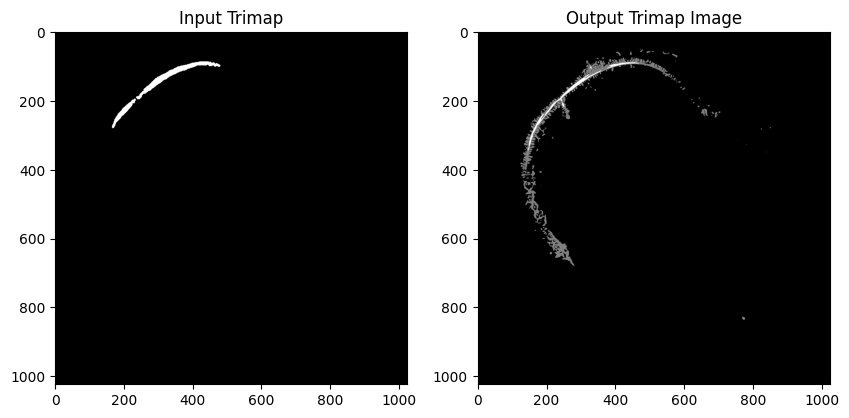

In [16]:
number = 41

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns of subplots

# Display the first image on the left
axs[0].imshow(input_trimap[:, :, number], cmap='gray')
axs[0].set_title('Input Trimap')

# Display the second image on the right
# Replace 'input_image2' with your second image variable
axs[1].imshow(output_trimap[:, :, number], cmap='gray')
axs[1].set_title('Output Trimap Image')

plt.show()


In [17]:
np.sqrt(np.mean((output_trimap - input_trimap) ** 2))

28.476046726131596

In [18]:
# from scipy.ndimage import gaussian_filter

# def label_propogation(trimap, window_size = 9, sigma =(1, 1, 1)):
#     temp_trimap = trimap.copy()
    
#     temp_trimap[trimap == 0] = -255
#     temp_trimap[trimap == 255] = 255
#     temp_trimap[trimap == 128] = 0
    
#     temp = gaussian_filter(temp_trimap,sigma=sigma, mode='constant', truncate=window_size)
    

#     temp[temp == 0] = 128
#     temp[temp > 0] = 255
#     temp[temp < 0] = 0
    
#     return temp 

Below, for better memory usage, instead of using sigma when calculating distance (O(n) computation), we scale the point cloud to achieve the same results in a single compution. For instance, if we want to scale sigma by n

$$e^{-d^{2}/2 (n\sigma)^{2}} = e^{-d^{2}/2 n^{2} \sigma^{2}} = e^{-d^{2}/2 \sigma^{2}} \times \frac{1}{n^{2}} = e^{-(d^{2}/n^{2})/2 \sigma^{2}} = e^{-(d/n)^{2}/2 \sigma^{2}}$$

Thus instead of $\sigma := n \sigma$, we can take scale distance $d:= d / n$

In [19]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

def gaussian(distance):
    sigma = 1.0 
    weight = np.exp(-(distance**2) / (2 * sigma**2))
    return weight

def label_propogation_pcl(trimap, window_size = 3, sigma =(1, 1, 1)):
    temp_trimap = trimap.copy()
    
    sigma = (1, 1, 3.1)

    distance_x = 0.325
    distance_y = 0.325
    distance_z = 1
    
    scale_factor_x = distance_x / sigma[0]
    scale_factor_y = distance_y / sigma[1]
    scale_factor_z = distance_z / sigma[2]

    no = np.argwhere(temp_trimap == 0)
    yes = np.argwhere(temp_trimap == 255)
    unknown = np.argwhere(temp_trimap == 128)

    # convert to point cloud for 0, 128, 255
    point_cloud_no = no * [scale_factor_x, scale_factor_y, scale_factor_z]
    point_cloud_yes = yes * [scale_factor_x, scale_factor_y, scale_factor_z]
    point_cloud_unknown = unknown * [scale_factor_x, scale_factor_y, scale_factor_z]

    # concatenate 'no' and 'yes' point clouds
    point_cloud_known = np.concatenate((point_cloud_no, point_cloud_yes), axis=0)
    labels_known = np.concatenate((np.zeros(len(point_cloud_no)), np.ones(len(point_cloud_yes))), axis=0)

    # apply weighted knn on the unknowns finding nearest in yes + no
    knn = KNeighborsClassifier(n_neighbors=100, weights=gaussian)
    knn.fit(point_cloud_known, labels_known)

    labels_unknown = knn.predict(point_cloud_unknown)

    # assign the value to the unknowns in the trimap
    for idx, point in enumerate(unknown):
        temp_trimap[tuple(point)] = labels_unknown[idx] * 255
    
    return temp_trimap


In [20]:
bayes = label_propogation_pcl(output_trimap)

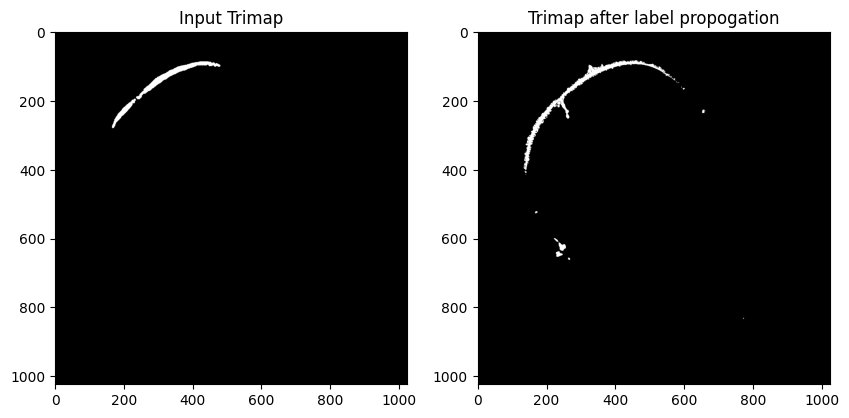

In [21]:
number = 41

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns of subplots

# Display the first image on the left
axs[0].imshow(input_trimap[:, :, number], cmap='gray')
axs[0].set_title('Input Trimap')

# Display the second image on the right
# Replace 'input_image2' with your second image variable
axs[1].imshow(bayes[:, :, number], cmap='gray')
axs[1].set_title('Trimap after label propogation')

plt.show()


In [22]:
# small_gone = ski.morphology.remove_small_objects(bayes==255, min_size=100000, connectivity=4)

In [23]:
# number = 41

# fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns of subplots

# # Display the first image on the left
# axs[0].imshow(input_trimap[:, :, number], cmap='gray')
# axs[0].set_title('Input Trimap')

# # Display the second image on the right
# # Replace 'input_image2' with your second image variable
# axs[1].imshow(small_gone[:, :, number], cmap='gray')
# axs[1].set_title('Small objects removed')

# plt.show()


In [24]:
# ski.morphology.remove_small_objects(bayes==255, min_size=10000, connectivity=4)

In [25]:
indices = np.argwhere(bayes == 255  )

scale_factor_x = 0.325
scale_factor_y = 0.325
scale_factor_z = 1


indices[:, 0] = indices[:, 0] * scale_factor_x
indices[:, 1] = indices[:, 1] * scale_factor_y
indices[:, 2] = indices[:, 2] * scale_factor_z

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(indices)


pcd, ind = pcd.remove_statistical_outlier(nb_neighbors=1000, std_ratio=1)



In [26]:
# point cloud without removing small objects
o3d.visualization.draw_geometries([pcd])

In [27]:
# indices = np.argwhere(ski.morphology.remove_small_objects(bayes==255, min_size=10000, connectivity=4))

# scale_factor_x = 0.325
# scale_factor_y = 0.325
# scale_factor_z = 1


# indices[:, 0] = indices[:, 0] * scale_factor_x
# indices[:, 1] = indices[:, 1] * scale_factor_y
# indices[:, 2] = indices[:, 2] * scale_factor_z

# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(indices)


# pcd, ind = pcd.remove_statistical_outlier(nb_neighbors=1000, std_ratio=1)


# o3d.visualization.draw_geometries([pcd])

In [28]:
import warnings
warnings.filterwarnings("ignore")

alpha = 10
print(f"alpha={alpha:.3f}")
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha)
mesh.compute_vertex_normals()



alpha=10.000
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra

TriangleMesh with 71329 points and 334448 triangles.

In [29]:
def pick_points(mesh):
    print("1) Please pick points using [shift + left click]")
    print("   Press [shift + right click] to undo point picking")
    print("2) After picking points, press 'Q' to close the window")

    vis = o3d.visualization.VisualizerWithVertexSelection()
    vis.create_window()
    vis.add_geometry(mesh)
    vis.run()  # user picks points
    vis.destroy_window()

    return vis.get_picked_points()

In [30]:
picked_points = pick_points(mesh)

points = []

for picked_point in picked_points:
    # print(f"Index: {picked_point.index}, Coordinates: {picked_point.coord}")
    points.append(picked_point.coord)
    
points = np.array(points)

1) Please pick points using [shift + left click]
   Press [shift + right click] to undo point picking
2) After picking points, press 'Q' to close the window
[Open3D INFO] Clearing all points from selection.
